## POS tagging using modified Viterbi

In [1]:
# *********************************************************************************************************************
# * @Assignment: Syntactic Analysis : HMMs and Viterbi algorithm for POS tagging
# *********************************************************************************************************************
# *
# * @author    : Poonam Yadav
# * @version   : v0.1.1
# * @StartDate : 24th-August-2020
# 
# *********************************************************************************************************************

In [3]:
### 1.Importing required libraries

In [4]:
# *********************************************************************************************************************
# * Suppress Warnings
# *********************************************************************************************************************
import warnings
warnings.filterwarnings('ignore')

In [12]:
# *********************************************************************************************************************
# * Import Libraries 
# *********************************************************************************************************************
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import datetime
import nltk, re, pprint
import requests
import time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [13]:
### Data Preparation

In [14]:
import nltk

In [15]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\AJAY\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [16]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [18]:
# Splitting the data into train and validation set (95:5 ration respectively)
random.seed(1234)
train_set , validation_set = train_test_split(nltk_data , test_size = 0.05)

In [19]:
print(len(train_set))
print(len(validation_set))

3718
196


In [20]:
# List of tagged words in training set
train_tagged = [tup for sent in train_set for tup in sent]
len(train_tagged)

95804

In [22]:
# List of tagged words in validation set
validation_tagged = [tup for sent in validation_set for tup in sent]
len(validation_tagged)

4872

In [23]:
#tokens
tokens = [pair[0] for pair in train_tagged]

In [25]:
tokens[:12]

['Stephen',
 'Salmore',
 ',',
 'a',
 'political',
 'scientist',
 'at',
 'New',
 'Jersey',
 "'s",
 'Eagleton',
 'Institute']

In [29]:
# tags
tags = set([pair[1] for pair in train_tagged])
print(tags)

{'ADP', 'ADJ', 'VERB', 'PRON', 'NUM', 'ADV', 'DET', 'X', '.', 'CONJ', 'NOUN', 'PRT'}


In [26]:
vocabulary = set(tokens)
print(len(vocabulary))

12089


In [30]:
# emission probabilities
t = len(tags)
v = len(vocabulary)
w_given_t = np.zeros((t, v))

In [31]:
w_given_t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [37]:
# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# he
print("\n", "he")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(26, 6090)
(0, 12905)
(0, 27442) 


 will
(1, 27442)
(266, 12905)

 he
(7, 27442)
(1, 12905)


In [38]:
# Transition probabilities
def t2_given_t1(t2, t1, train_bag = train_tagged):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [39]:
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('.', 'NOUN'))
print(t2_given_t1('VERB', 'NOUN'))

(4264, 6090)
(5312, 8314)
(1420, 12905)
(6606, 27442)
(4026, 27442)


In [40]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))


(1943, 11145)
(982, 11145)
(2480, 11145)


In [42]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix


array([[1.69166941e-02, 1.06819876e-01, 8.19236133e-03, 6.84115365e-02,
        6.30918220e-02, 1.38312588e-02, 3.24609011e-01, 3.47909369e-02,
        3.98978628e-02, 7.44760095e-04, 3.21204394e-01, 1.48952019e-03],
       [7.61904791e-02, 6.63382560e-02, 1.23152705e-02, 6.56814431e-04,
        2.08538584e-02, 4.43349732e-03, 4.92610829e-03, 2.11822651e-02,
        6.48604259e-02, 1.70771759e-02, 7.00164199e-01, 1.10016419e-02],
       [9.13599357e-02, 6.50910512e-02, 1.70786515e-01, 3.47152278e-02,
        2.26268880e-02, 8.15962777e-02, 1.33824095e-01, 2.18287483e-01,
        3.51026729e-02, 5.19178621e-03, 1.10034868e-01, 3.13831866e-02],
       [2.22734250e-02, 7.25806430e-02, 4.88863289e-01, 7.68049154e-03,
        6.91244239e-03, 3.37941647e-02, 9.98463947e-03, 9.44700465e-02,
        4.03225794e-02, 5.37634408e-03, 2.06221193e-01, 1.15207378e-02],
       [3.50877196e-02, 3.18168290e-02, 1.81385670e-02, 1.48676778e-03,
        1.83467150e-01, 2.67618196e-03, 3.56824254e-03, 2.11

In [43]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,ADP,ADJ,VERB,PRON,NUM,ADV,DET,X,.,CONJ,NOUN,PRT
ADP,0.016917,0.106820,0.008192,0.068412,0.063092,0.013831,0.324609,0.034791,0.039898,0.000745,0.321204,0.001490
ADJ,0.076190,0.066338,0.012315,0.000657,0.020854,0.004433,0.004926,0.021182,0.064860,0.017077,0.700164,0.011002
VERB,0.091360,0.065091,0.170787,0.034715,0.022627,0.081596,0.133824,0.218287,0.035103,0.005192,0.110035,0.031383
PRON,0.022273,0.072581,0.488863,0.007680,0.006912,0.033794,0.009985,0.094470,0.040323,0.005376,0.206221,0.011521
NUM,0.035088,0.031817,0.018139,0.001487,0.183467,0.002676,0.003568,0.211418,0.116860,0.013381,0.355040,0.027059
ADV,0.117959,0.131213,0.342280,0.014911,0.032140,0.079854,0.068588,0.023857,0.136183,0.007290,0.031146,0.014579
DET,0.009261,0.205196,0.038850,0.003608,0.022612,0.012629,0.005533,0.044744,0.017922,0.000481,0.638922,0.000241
X,0.146840,0.017108,0.205132,0.056233,0.002851,0.025345,0.054332,0.075083,0.162205,0.010455,0.060827,0.183589
.,0.091431,0.043517,0.088111,0.066487,0.080574,0.053028,0.174338,0.027456,0.092149,0.058053,0.222521,0.002243
CONJ,0.050855,0.117892,0.155340,0.059177,0.042534,0.056403,0.120666,0.008322,0.034674,0.000462,0.348590,0.005086


In [44]:
tags_df.loc['.', :]

ADP     0.091431
ADJ     0.043517
VERB    0.088111
PRON    0.066487
NUM     0.080574
ADV     0.053028
DET     0.174338
X       0.027456
.       0.092149
CONJ    0.058053
NOUN    0.222521
PRT     0.002243
Name: ., dtype: float32

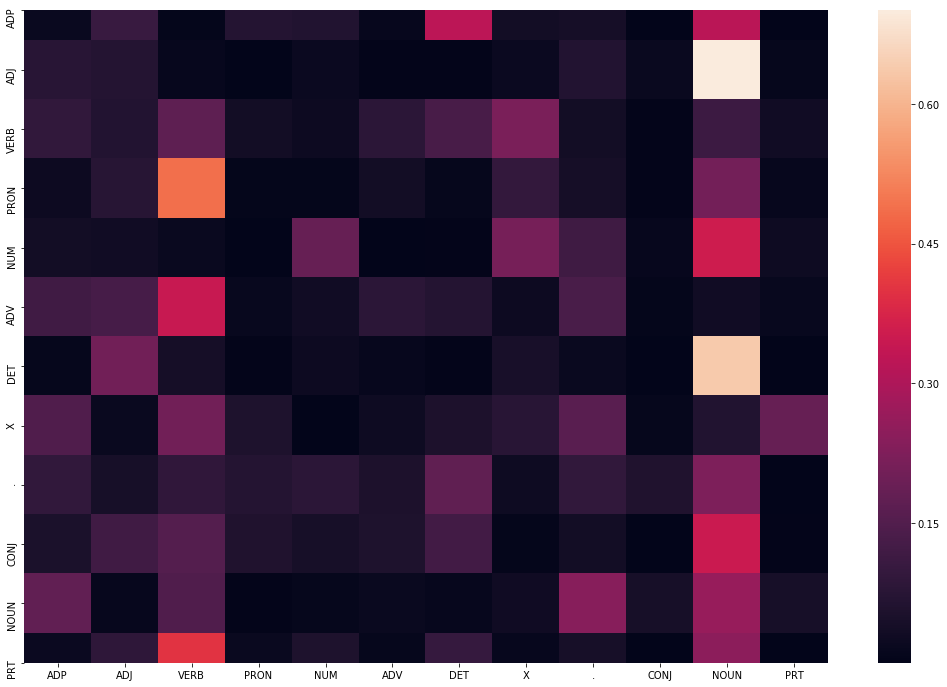

In [45]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


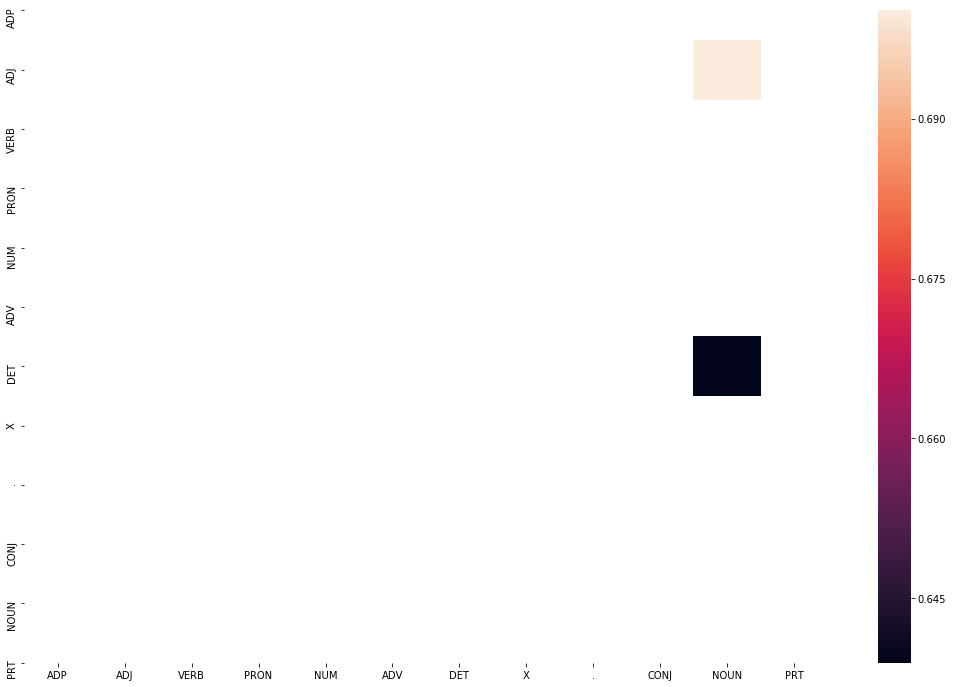

In [46]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [47]:
len(train_tagged)

95804

In [48]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



#### Evaluating tagging accuracy

In [49]:
# Running on entire validation dataset 

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(validation_set)) for x in range(5)]

# list of sents
validation_run = [validation_set[i] for i in rndom]

# list of tagged words
validation_run_base = [tup for sent in validation_run for tup in sent]

# list of untagged words
validation_tagged_words = [tup[0] for sent in validation_run for tup in sent]
validation_run

[[('Ten', 'NUM'),
  ('shirt-sleeved', 'ADJ'),
  ('ringers', 'NOUN'),
  ('stand', 'VERB'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('circle', 'NOUN'),
  (',', '.'),
  ('one', 'NUM'),
  ('foot', 'NOUN'),
  ('ahead', 'ADV'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('other', 'ADJ'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('prize-fighter', 'NOUN'),
  ("'s", 'PRT'),
  ('stance', 'NOUN'),
  (',', '.'),
  ('each', 'DET'),
  ('pulling', 'VERB'),
  ('a', 'DET'),
  ('rope', 'NOUN'),
  ('that', 'DET'),
  ('*T*-225', 'X'),
  ('disappears', 'VERB'),
  ('through', 'ADP'),
  ('a', 'DET'),
  ('small', 'ADJ'),
  ('hole', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('high', 'ADJ'),
  ('ceiling', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('ringing', 'NOUN'),
  ('chamber', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('So', 'ADP'),
  ('the', 'DET'),
  ('focus', 'NOUN'),
  ('turned', 'VERB'),
  ('to', 'PRT'),
  ('other', 'ADJ'),
  ('fixed-income', 'ADJ'),
  ('markets', 'NOUN'),
  (',', '.'),
  ('corporate', 'ADJ'),
 

In [50]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(validation_tagged_words)
end = time.time()
difference = end-start

In [51]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  50.285765171051025
[('Ten', 'ADP'), ('shirt-sleeved', 'ADP'), ('ringers', 'NOUN'), ('stand', 'VERB'), ('in', 'ADP'), ('a', 'DET'), ('circle', 'ADP'), (',', '.'), ('one', 'NUM'), ('foot', 'ADP'), ('ahead', 'ADV'), ('of', 'ADP'), ('the', 'DET'), ('other', 'ADJ'), ('in', 'ADP'), ('a', 'DET'), ('prize-fighter', 'ADP'), ("'s", 'PRT'), ('stance', 'NOUN'), (',', '.'), ('each', 'DET'), ('pulling', 'ADP'), ('a', 'DET'), ('rope', 'ADP'), ('that', 'DET'), ('*T*-225', 'ADP'), ('disappears', 'ADP'), ('through', 'ADP'), ('a', 'DET'), ('small', 'ADJ'), ('hole', 'ADP'), ('in', 'ADP'), ('the', 'DET'), ('high', 'ADJ'), ('ceiling', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('ringing', 'NOUN'), ('chamber', 'ADP'), ('.', '.'), ('``', '.'), ('So', 'ADV'), ('the', 'DET'), ('focus', 'NOUN'), ('turned', 'VERB'), ('to', 'PRT'), ('other', 'ADJ'), ('fixed-income', 'ADP'), ('markets', 'NOUN'), (',', '.'), ('corporate', 'ADJ'), ('and', 'CONJ'), ('mortgages', 'NOUN'), ('in', 'ADP'), ('particula

In [53]:
# accuracy
check = [i for i, j in zip(tagged_seq, validation_run_base) if i == j] 

In [55]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.8813559322033898

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [57]:
## Modification -1: all unknown words are replaced by Noun (Noun being the most common tag)

def Viterbi_mod1(test_words, train_bag = train_tagged):
    tagged_seq = Viterbi(test_words)
    V = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in V:
            Viterbi_tags[key] = 'NOUN'
            
    
    return list(zip(words, Viterbi_tags))

In [58]:
validation_Viterbimod1 = Viterbi_mod1(validation_tagged_words)

In [59]:
# modification 1 accuracy

check_mod1 = [i for i, j in zip(validation_Viterbimod1, validation_run_base) if i == j] 
accuracy1 = len(check_mod1)/len(validation_Viterbimod1)

accuracy1


0.940677966101695

In [64]:
## Viterbi Modification -2: 
## 1. all unknown words with first letter capital/ all letters capitals are tagged as Noun, numbers are tagged as NUM, words ending with '-ous' as ADJ, and rest as Noun

def Viterbi_mod2(test_words, train_bag = train_tagged):
    tagged_seq = Viterbi(test_words)
    V = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in V:
            ## word ending with '-ous'
            if word[-3:] == 'ous':
                Viterbi_tags[key] = 'ADJ'
            
            ## if word is number
            elif (word.isdigit() == True or word[:-2].isdigit() == True):
                Viterbi_tags[key] = 'NUM'
                
            ## all letters capitalised
            elif word.upper() == word:
                Viterbi_tags[key] = 'NOUN'
                
            ## first letter is capitalised:
            elif word[0].upper() == word[0]:
                Viterbi_tags[key] = 'NOUN' 
                
            else: 
                Viterbi_tags[key] = 'NOUN'
    
    return list(zip(words, Viterbi_tags))

In [65]:
validation_Viterbimod2 = Viterbi_mod2(validation_tagged_words)

In [66]:
# modification 2 accuracy

check_mod2 = [i for i, j in zip(validation_Viterbimod2, validation_run_base) if i == j] 
accuracy2 = len(check_mod2)/len(validation_Viterbimod2)

accuracy1

0.940677966101695

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [68]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AJAY\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [69]:
## Testing
test_cases_shared = 'Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
test_words = word_tokenize(test_cases_shared)

In [70]:
# After modification -1 
start = time.time()
tagged_seq1_test = Viterbi_mod1(test_words)
end = time.time()
difference = end-start
tagged_seq1_test

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 

In [71]:
# After modification 2 
start = time.time()
tagged_seq2_test = Viterbi_mod1(test_words)
end = time.time()
difference = end-start
tagged_seq2_test

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 